In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

### Generate a synthetic distribution and calculate S

In [13]:
data, pars = dive.generateMultiGauss(nt = 160, seed = 129, k = 0.5, sigma = 0.01, V0 = 1.15, t_edges=[-0.1,2.5])

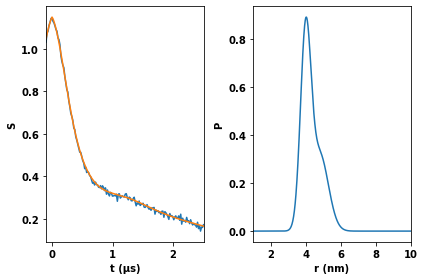

In [14]:
t = data['t']
Vexp = data['V']

fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, Vexp)
line1 = ax[0].plot(t, data['V0'])
line2 = ax[1].plot(data['r'], data['P'])

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(data['r']),max(data['r'])], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

### Initialize parameters and matrices

-1.1673048252


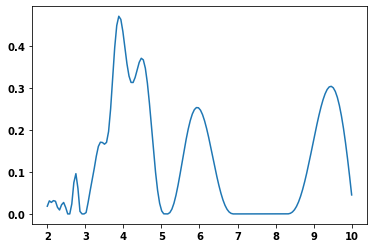

In [21]:
# r vector
r = np.linspace(2,10,150)
dr = r[1] - r[0]

fit = dl.fitmodel(Vexp,t,r,'P',dl.bg_exp,dl.ex_4pdeer, regparam = 10**(-1.1673048252))
plt.plot(r,fit.P)
print(np.log10(fit.regparam))

# kernel regularization operator
K0 = dl.dipolarkernel(t,r,integralop=False)   # kernel matrix
L = dl.regoperator(np.linspace(1,len(r),len(r)), 2)
LtL = np.matmul(np.transpose(L),L)
K0tK0 = np.matmul(np.transpose(K0),K0)

# parameters for delta distribution
a0 = 0.01
b0 = 1e-6

In [24]:
print(fit.exparam)
print(fit.bgparam)

[0.99995742]
[1.15063515e-16]


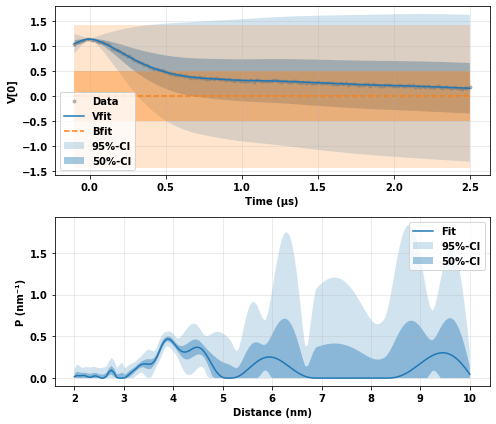

In [22]:
fit.plot();

### Setup model

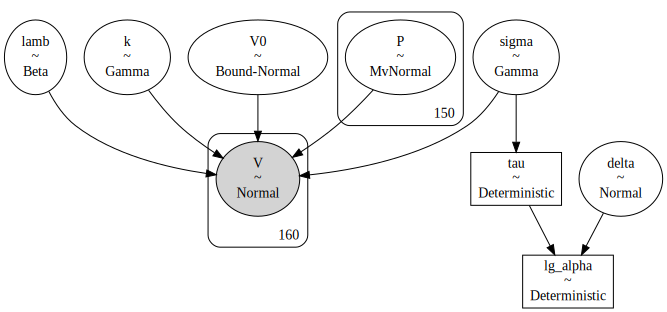

In [16]:
with pm.Model() as model:
    # Noise --------------------------------------------------------------
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter -------------------------------------------
    delta = pm.Normal('delta', mu = 20000, sigma = 10000)
    lg_alpha = pm.Deterministic('lg_alpha', np.log10(np.sqrt(delta/tau)) )
    
    # Time Domain --------------------------------------------------------
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal, lower=0.0)('V0', mu=1, sigma=0.2)

    # Background ---------------------------------------------------------
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(t, k)

    # Calculate matrices and operators -----------------------------------
    Kintra = (1-lamb) + lamb*K0
    B_ = T.transpose( T.tile(B,(len(r),1)) )
    K = V0*Kintra*B_*dr
    KtK = T.dot(T.transpose(K),K)

    # invSigma = tau*KtK + delta*LtL
    invSigma = K0tK0 + LtL

    # Distance distribution ----------------------------------------------
    P = pm.MvNormal("P", mu = np.ones_like(r), tau = invSigma, shape = len(r))     

    # Time domain model ---------------------------------------------------
    Vmodel = pm.math.dot(K,P)

    # Likelihood ----------------------------------------------------------
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vexp)

pm.model_to_graphviz(model) 

### Run sampler

In [17]:
with model:
    step_P = dive.SamplePfromV(P, K0, LtL, t, Vexp, r, delta, sigma, k, lamb, V0)
    step_delta = dive.randDelta(delta, a0, b0, L, P)
    trace = pm.sample(step = [step_P, step_delta], chains=4, cores=4, draws=10000, tune= 1000, return_inferencedata=False, progressbar = False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>SamplePfromV: [P]
>randDelta: [delta]
>NUTS: [k, V0, lamb, sigma]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 1536 seconds.
The acceptance probability does not match the target. It is 0.9267755042095698, but should be close to 0.8. Try to increase the number of tuning steps.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9295773160732224, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


mean         sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
k          0.463      0.022      0.422      0.501      0.001    0.001   
λ          0.556      0.028      0.509      0.607      0.001    0.001   
V₀         1.153      0.005      1.143      1.163      0.000    0.000   
σ          0.010      0.001      0.009      0.011      0.000    0.000   
δ      40505.824  18575.443  11738.474  75183.546    465.942  329.531   
lg(α)      0.276      0.104      0.087      0.475      0.003    0.002   

       ess_bulk  ess_tail  r_hat  
k         518.0     705.0    1.0  
λ         497.0     696.0    1.0  
V₀      11035.0   13449.0    1.0  
σ        5867.0    3622.0    1.0  
δ        1494.0    3189.0    1.0  
lg(α)    1555.0    3242.0    1.0

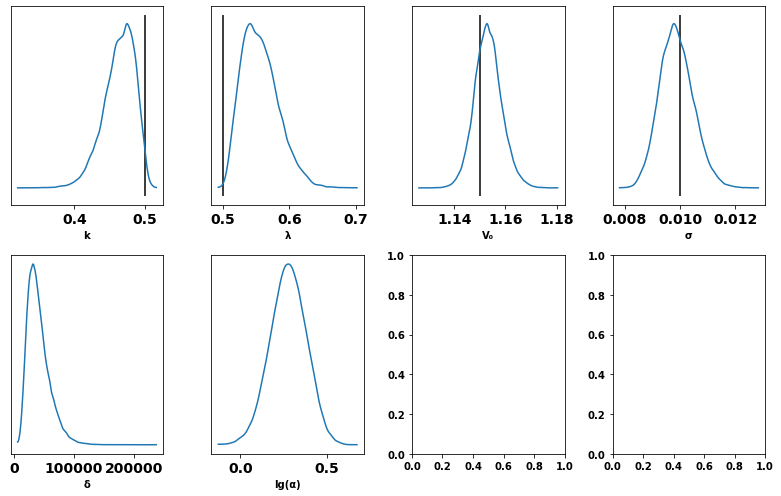

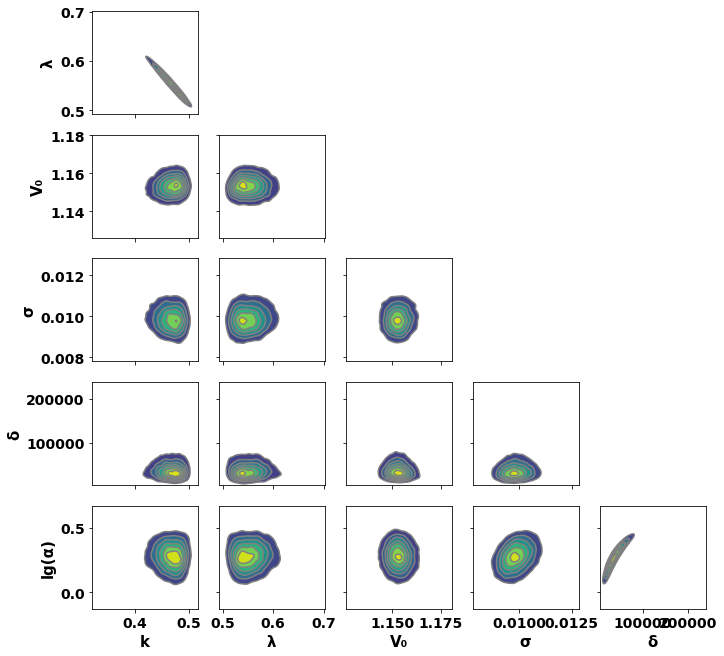

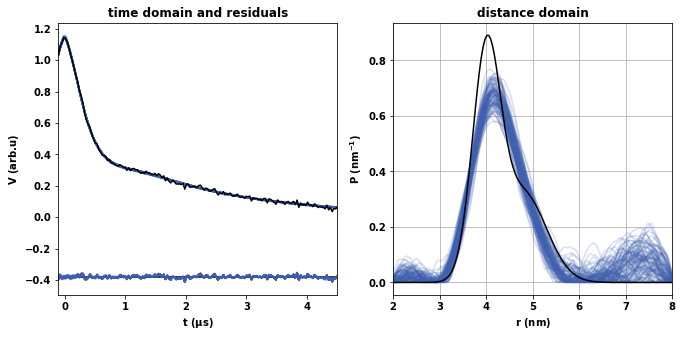

In [18]:
Ptrue = dl.dd_gauss2(r,pars['gaussians'])
dive.summary(trace, model, Vexp, t, r, Pref = Ptrue, GroundTruth = pars)  

### Analysis

mean         sd    hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
k          0.108      0.117     0.000      0.360      0.041     0.030   
λ          0.786      0.077     0.613      0.866      0.030     0.022   
V₀         1.141      0.006     1.132      1.151      0.002     0.001   
σ          0.010      0.001     0.008      0.011      0.000     0.000   
δ      33036.842  18736.614  7387.129  68367.975   3398.876  2426.821   
lg(α)      0.209      0.117    -0.010      0.431      0.019     0.014   

       ess_bulk  ess_tail  r_hat  
k          11.0      27.0   1.47  
λ           6.0      28.0   1.67  
V₀         10.0      36.0   1.30  
σ          17.0      50.0   1.18  
δ          22.0     287.0   1.13  
lg(α)      37.0     743.0   1.09

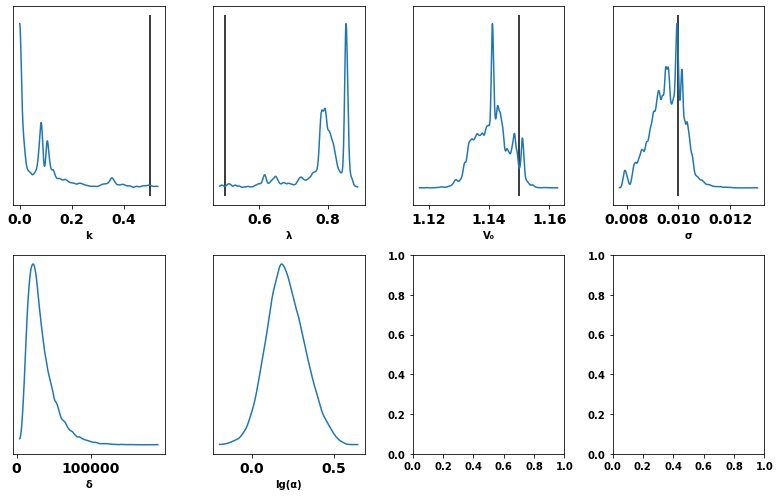

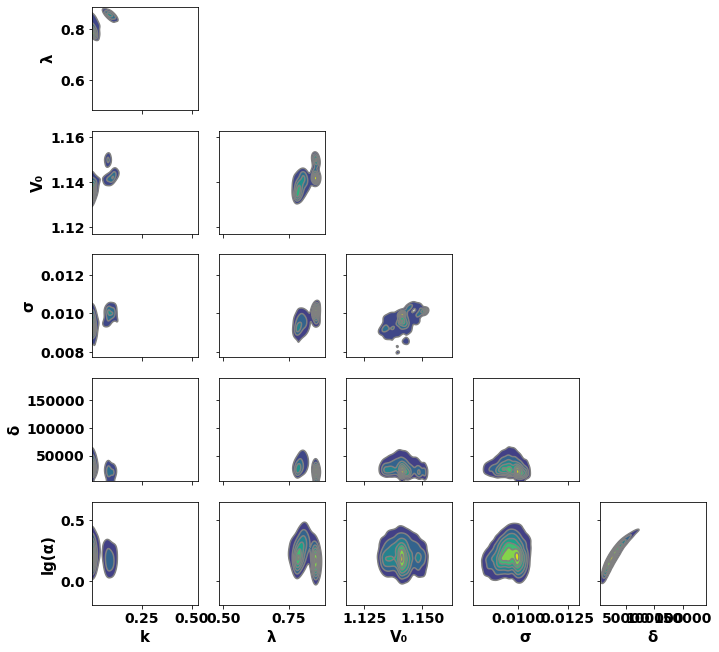

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


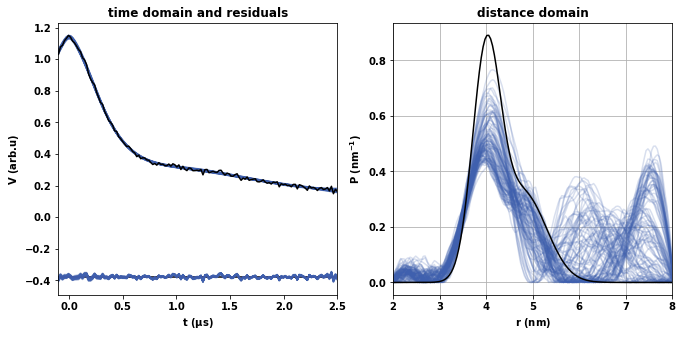

In [9]:
Ptrue = dl.dd_gauss2(r,pars['gaussians'])
dive.summary(trace, model, Vexp, t, r, Pref = Ptrue, GroundTruth = pars)  

mean         sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
k          0.462      0.026      0.414      0.503      0.002    0.001   
λ          0.558      0.032      0.505      0.615      0.002    0.001   
V₀         1.153      0.005      1.144      1.162      0.000    0.000   
σ          0.010      0.001      0.009      0.011      0.000    0.000   
δ      39710.400  18404.594  10958.964  73695.285    513.575  363.235   
lg(α)      0.270      0.104      0.075      0.468      0.003    0.002   

       ess_bulk  ess_tail  r_hat  
k         252.0     571.0   1.01  
λ         243.0     500.0   1.01  
V₀       2061.0    4073.0   1.01  
σ         831.0    1179.0   1.01  
δ        1155.0    2736.0   1.00  
lg(α)    1109.0    2743.0   1.00

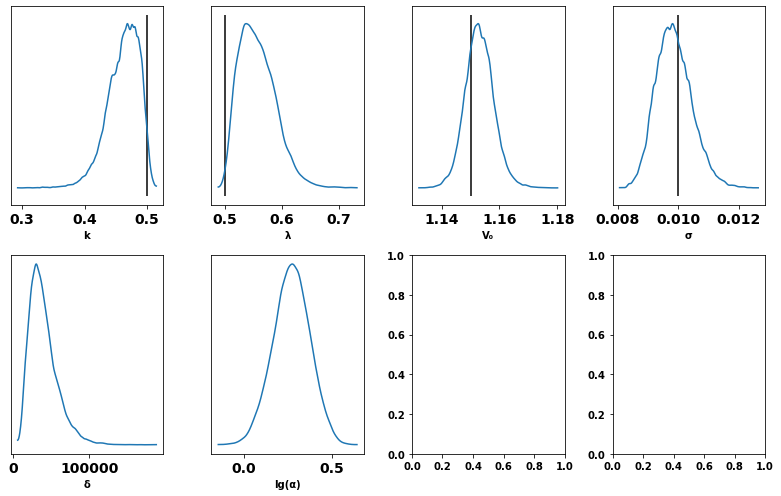

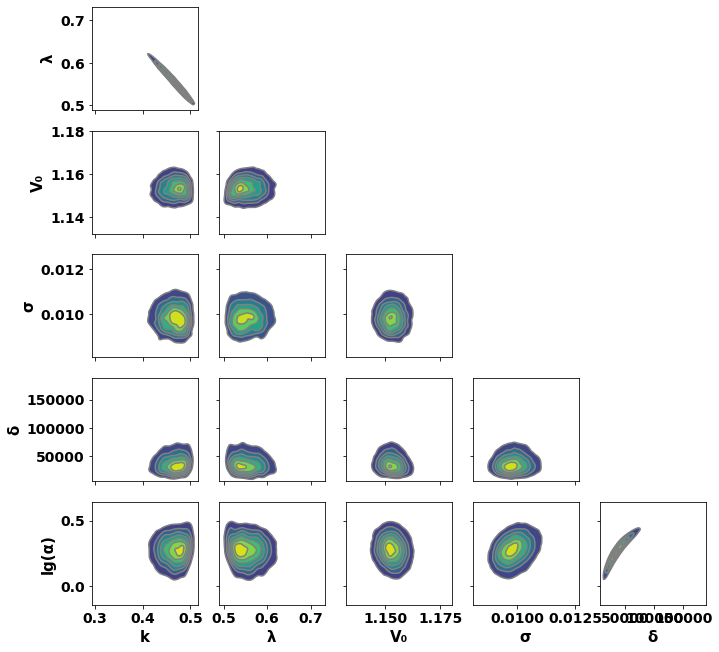

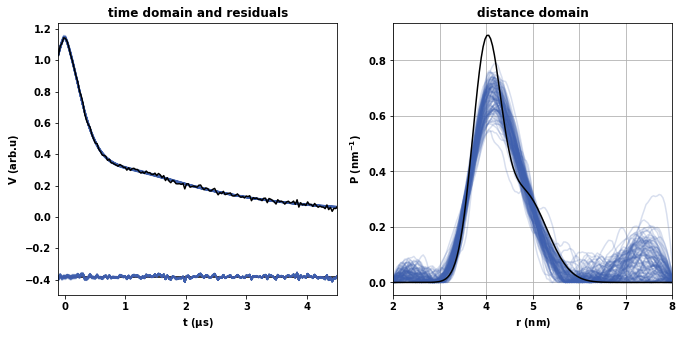

In [15]:
Ptrue = dl.dd_gauss2(r,pars['gaussians'])
dive.summary(trace, model, Vexp, t, r, Pref = Ptrue, GroundTruth = pars)  